In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Считывание датасета и просмотр статистик

##### Датасет переписи населения, на основе которого нужно предсказать - превысит ли доход $ 50K/год или нет.

In [2]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
        'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'target']
df = pd.read_csv("adult.data", names = names)

In [3]:
# Датасет содержит числовые и категориальные признаки
df.head()

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  target  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
target            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
# числовые признаки
df.describe()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

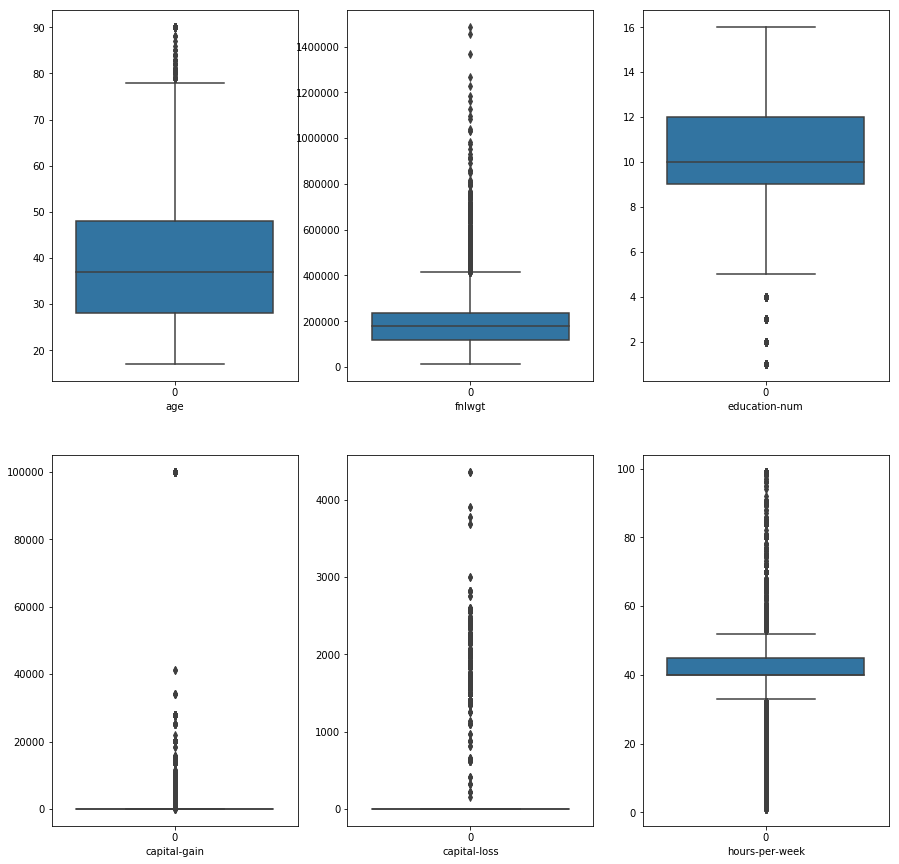

In [6]:
# Распределение числовых признаков
# 'capital-gain' и 'capital-loss' в основном содержат нули, так же у всех тяжелые хвосты, переходящие в выбросы
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
j = 0
for i in df.describe().columns:
    ax = axs[j//3,j%3]
    ax = sns.boxplot(data = df[i], ax=ax)
    ax.set_xlabel(i)
    j += 1
plt.show()

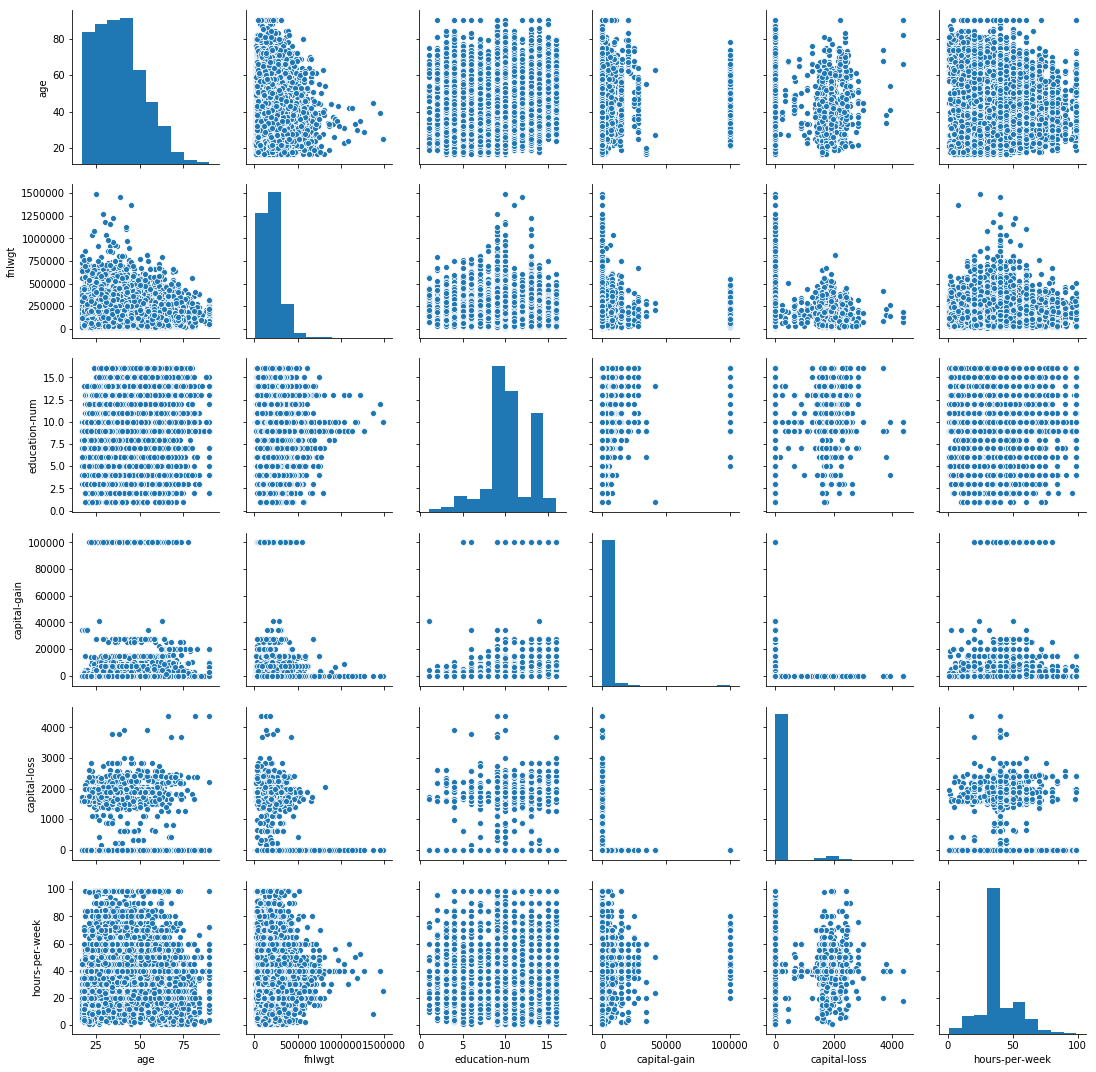

In [7]:
sns.pairplot(df)
plt.show()

In [8]:
# категориальные признаки
df.describe(include=['object'])

workclass education       marital-status       occupation relationship  \
count      32561     32561                32561            32561        32561   
unique         9        16                    7               15            6   
top      Private   HS-grad   Married-civ-spouse   Prof-specialty      Husband   
freq       22696     10501                14976             4140        13193   

          race    sex  native-country  target  
count    32561  32561           32561   32561  
unique       5      2              42       2  
top      White   Male   United-States   <=50K  
freq     27816  21790           29170   24720

In [9]:
# Переводим целевую перменную в бинарный признак
df['target'] = df['target'].apply(lambda x: 0 if x==' <=50K' else 1)

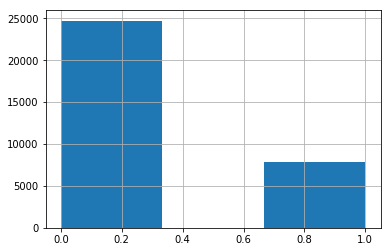

In [10]:
# целевая переменная несбалансированная, но не критично
df['target'].hist(bins=3)
plt.show()

In [11]:
# Пропусков нет
df.isnull().sum().sort_values(ascending=False)

target            0
native-country    0
hours-per-week    0
capital-loss      0
capital-gain      0
sex               0
race              0
relationship      0
occupation        0
marital-status    0
education-num     0
education         0
fnlwgt            0
workclass         0
age               0
dtype: int64

In [12]:
# функция для отеделения числовых признаков
def num(data):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    return data.select_dtypes(include=numerics).drop(['target'], axis=1)

# функция для отделения категориальных признаков
def obj(data):
    category = ['object']
    return data.select_dtypes(include=category)

In [13]:
# собираем pipeline для преобразований признаков, добавляем нормализатор числовых признаков - для лог регрессии
# числовые признаки:
numerical_selector = FunctionTransformer(num, validate=False)
scaler = StandardScaler() 

numerical_features_scaler = Pipeline([
    ("numerical_selector", numerical_selector),
    ('scaler', scaler)
])
numerical_features_scaler.fit_transform(df).shape

(32561, 6)

In [14]:
# категориальные признаки, кодируем их бинарными переменными:
category_selector = FunctionTransformer(obj, validate=False)
one_hot = OneHotEncoder(handle_unknown='ignore', sparse=False)

category_features_onehot = Pipeline([
    ("category_selector", category_selector),
    ("one_hot", one_hot)
])
category_features_onehot.fit_transform(df).shape

(32561, 102)

In [15]:
# соединяем признаки:
preprocessing_pipeline = FeatureUnion([
    ("numerical", numerical_features_scaler),
    ("categorical", category_features_onehot)
])
preprocessing_pipeline.fit_transform(df).shape

(32561, 108)

## Подберем параметры и проверим качество работы XGBoost, GradientBoostingClassifier, CatBoost и LightGBM на метрике f1

##### XGBoost:

In [16]:
# добавляем в pipeline XGBoost по умолчанию
XGB = XGBClassifier()
GBC = GradientBoostingClassifier()
CAT = CatBoostClassifier()
LGBM = LGBMClassifier()

pipe = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("modelling", XGB)
])
# посмотрим какие параметры можем перебрать на сетке
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'modelling', 'preprocessing__n_jobs', 'preprocessing__transformer_list', 'preprocessing__transformer_weights', 'preprocessing__verbose', 'preprocessing__numerical', 'preprocessing__categorical', 'preprocessing__numerical__memory', 'preprocessing__numerical__steps', 'preprocessing__numerical__verbose', 'preprocessing__numerical__numerical_selector', 'preprocessing__numerical__scaler', 'preprocessing__numerical__numerical_selector__accept_sparse', 'preprocessing__numerical__numerical_selector__check_inverse', 'preprocessing__numerical__numerical_selector__func', 'preprocessing__numerical__numerical_selector__inv_kw_args', 'preprocessing__numerical__numerical_selector__inverse_func', 'preprocessing__numerical__numerical_selector__kw_args', 'preprocessing__numerical__numerical_selector__validate', 'preprocessing__numerical__scaler__copy', 'preprocessing__numerical__scaler__with_mean', 'preprocessing__numerical__scaler__with_std', 'p

In [17]:
%%time
param_grid = {
    'modelling__n_estimators' : [100, 200, 300],
    'modelling__learning_rate' : [0.05, 0.1, 0.2, 0.3],
    'modelling__booster' : ['gbtree', 'gblinear', 'dart']
}
search_xgb = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
search_xgb.fit(df, df['target'])

Wall time: 15min 53s


In [18]:
# лучшие параметры модели XGBoost
search_xgb.best_params_

{'modelling__booster': 'gbtree',
 'modelling__learning_rate': 0.3,
 'modelling__n_estimators': 300}

In [19]:
# лучшая f1 метрика XGBoost
search_xgb.best_score_

0.7147225291841844

##### GradientBoostingClassifier:

In [20]:
%%time
param_grid = {
    'modelling__n_estimators' : [100, 200, 300],
    'modelling__learning_rate' : [0.05, 0.1, 0.2, 0.3],
    'modelling__loss' : ['deviance', 'exponential']
}
# Передаём в pipeline GradientBoostingClassifier от Sklearn
search_gbc = GridSearchCV(pipe.set_params(modelling=GBC), param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
search_gbc.fit(df, df['target'])

Wall time: 18min 20s


In [21]:
# лучшие параметры модели GradientBoostingClassifier
search_gbc.best_params_

{'modelling__learning_rate': 0.3,
 'modelling__loss': 'deviance',
 'modelling__n_estimators': 200}

In [22]:
# лучшая f1 метрика GradientBoostingClassifier
search_gbc.best_score_

0.7128506035571358

##### CatBoost с классическим кодированием категориальных признаков:

In [25]:
%%time
param_grid = {
'modelling__learning_rate' : [0.05, 0.1, 0.2, 0.3],
'modelling__iterations' : [500, 1000, 1500],
'modelling__l2_leaf_reg' : [1, 2, 3, 4]
}
# Передаём в pipeline CatBoost от Яндекса
search_cat = GridSearchCV(pipe.set_params(modelling=CAT), param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
search_cat.fit(df, df['target'])

0:	learn: 0.5950099	total: 71.9ms	remaining: 35.9s
1:	learn: 0.5253325	total: 83.1ms	remaining: 20.7s
2:	learn: 0.4767263	total: 94.9ms	remaining: 15.7s
3:	learn: 0.4410826	total: 106ms	remaining: 13.2s
4:	learn: 0.4114693	total: 118ms	remaining: 11.7s
5:	learn: 0.3909700	total: 129ms	remaining: 10.7s
6:	learn: 0.3764358	total: 140ms	remaining: 9.89s
7:	learn: 0.3634578	total: 155ms	remaining: 9.53s
8:	learn: 0.3565819	total: 168ms	remaining: 9.16s
9:	learn: 0.3497004	total: 179ms	remaining: 8.78s
10:	learn: 0.3434384	total: 191ms	remaining: 8.49s
11:	learn: 0.3379566	total: 202ms	remaining: 8.23s
12:	learn: 0.3341085	total: 214ms	remaining: 8.01s
13:	learn: 0.3300314	total: 225ms	remaining: 7.81s
14:	learn: 0.3267019	total: 237ms	remaining: 7.65s
15:	learn: 0.3238802	total: 248ms	remaining: 7.5s
16:	learn: 0.3214032	total: 260ms	remaining: 7.38s
17:	learn: 0.3192944	total: 273ms	remaining: 7.3s
18:	learn: 0.3179119	total: 285ms	remaining: 7.22s
19:	learn: 0.3147872	total: 296ms	remain

In [26]:
# лучшие параметры модели CatBoost
search_cat.best_params_

{'modelling__iterations': 500,
 'modelling__l2_leaf_reg': 1,
 'modelling__learning_rate': 0.1}

In [27]:
# лучшая f1 метрика CatBoost
search_cat.best_score_

0.7155507086343915

##### CatBoost с кодированием категориальных признаков от яндекса:

In [28]:
%%time
param_grid = {
'modelling__learning_rate' : [0.05, 0.1, 0.2, 0.3],
'modelling__iterations' : [500, 1000, 1500],
'modelling__l2_leaf_reg' : [1, 2, 3, 4]
}
# Указываем алгоритму номера столбцов с кат. признаками (не названия, т.к pipeline выдаёт на выходе не dataframe, а array)
# И пропускаем шаг onehot кодирования
search_cat = GridSearchCV(pipe.set_params(modelling=CAT.set_params(cat_features = list(range(6, 14))), preprocessing__categorical__one_hot = 'passthrough'), 
                          param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
search_cat.fit(df, df['target'])

0:	learn: 0.6421915	total: 61.1ms	remaining: 1m 31s
1:	learn: 0.5998237	total: 103ms	remaining: 1m 17s
2:	learn: 0.5611412	total: 156ms	remaining: 1m 17s
3:	learn: 0.5287640	total: 209ms	remaining: 1m 18s
4:	learn: 0.5000523	total: 264ms	remaining: 1m 19s
5:	learn: 0.4739154	total: 306ms	remaining: 1m 16s
6:	learn: 0.4544963	total: 349ms	remaining: 1m 14s
7:	learn: 0.4356441	total: 384ms	remaining: 1m 11s
8:	learn: 0.4219698	total: 438ms	remaining: 1m 12s
9:	learn: 0.4100062	total: 482ms	remaining: 1m 11s
10:	learn: 0.4003785	total: 510ms	remaining: 1m 9s
11:	learn: 0.3908426	total: 563ms	remaining: 1m 9s
12:	learn: 0.3814121	total: 621ms	remaining: 1m 11s
13:	learn: 0.3748658	total: 674ms	remaining: 1m 11s
14:	learn: 0.3683264	total: 720ms	remaining: 1m 11s
15:	learn: 0.3628655	total: 773ms	remaining: 1m 11s
16:	learn: 0.3571857	total: 818ms	remaining: 1m 11s
17:	learn: 0.3532844	total: 860ms	remaining: 1m 10s
18:	learn: 0.3492216	total: 915ms	remaining: 1m 11s
19:	learn: 0.3454319	to

In [29]:
# лучшие параметры модели CatBoost с категориальными признаками от яндекса
search_cat.best_params_

{'modelling__iterations': 1500,
 'modelling__l2_leaf_reg': 4,
 'modelling__learning_rate': 0.05}

In [30]:
# лучшая f1 метрика CatBoost с категориальными признаками от яндекса
search_cat.best_score_

0.7160660432118161

##### LightGBM:

In [31]:
pipe.set_params(modelling=LGBM)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'modelling', 'preprocessing__n_jobs', 'preprocessing__transformer_list', 'preprocessing__transformer_weights', 'preprocessing__verbose', 'preprocessing__numerical', 'preprocessing__categorical', 'preprocessing__numerical__memory', 'preprocessing__numerical__steps', 'preprocessing__numerical__verbose', 'preprocessing__numerical__numerical_selector', 'preprocessing__numerical__scaler', 'preprocessing__numerical__numerical_selector__accept_sparse', 'preprocessing__numerical__numerical_selector__check_inverse', 'preprocessing__numerical__numerical_selector__func', 'preprocessing__numerical__numerical_selector__inv_kw_args', 'preprocessing__numerical__numerical_selector__inverse_func', 'preprocessing__numerical__numerical_selector__kw_args', 'preprocessing__numerical__numerical_selector__validate', 'preprocessing__numerical__scaler__copy', 'preprocessing__numerical__scaler__with_mean', 'preprocessing__numerical__scaler__with_std', 'p

In [32]:
%%time
param_grid = {
'modelling__n_estimators' : [100, 200, 300],   
'modelling__learning_rate' : [0.05, 0.1, 0.2, 0.3],
'modelling__boosting_type' : ['gbdt', 'dart', 'goss', 'rf'],
'modelling__class_weight' : ['balanced',  None]
}
# Передаём в pipeline LightGBM от Microsoft
search_lgbm = GridSearchCV(pipe.set_params(modelling=LGBM,  preprocessing__categorical__one_hot = one_hot), 
                           param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
search_lgbm.fit(df, df['target'])

Wall time: 2min 48s


In [33]:
# лучшие параметры модели LightGBM
search_lgbm.best_params_

{'modelling__boosting_type': 'gbdt',
 'modelling__class_weight': 'balanced',
 'modelling__learning_rate': 0.1,
 'modelling__n_estimators': 300}

In [34]:
# лучшая f1 метрика LightGBM
search_lgbm.best_score_

0.7180963412434062

### Вывод: 
###### Все алгоритмы отработали с почти одинаковым качеством на f1 метрике (0,71-0,72), в том числе и CatBoost со своим собственным кодированием кат. признаков.
###### Случайный лес отработал чуть хуже на этом же датасете f1 = 0,67.
### LightGBM показал очень высокую скорость работы, при чуть лучшем качестве работы